# PŘÍPRAVA DATASETU

### Načtení potřebných knihoven

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers , callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing
import pathlib
import pandas as pd
from sklearn.metrics import confusion_matrix , classification_report
import itertools

### Ověření grafických procesorů

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

## Načtení dat do potřebné datové struktury

### Cesty k datasetu

In [2]:
dataset_path = r"C:\Users\HP\Documents\GIT-BP\Screw_ds(50,30,20)"

train_path = pathlib.Path(dataset_path + '/train')
valid_path = pathlib.Path(dataset_path + '/valid')
test_path  = pathlib.Path(dataset_path + '/test')

### Vytvoření datové struktury

In [3]:
labels='inferred'
    #Either "inferred" (labels are generated from the directory structure),or a list/tuple of integer labels of the same size as the number of image files found in the directory.
    #Labels should be sorted according to the alphanumeric order of the image file paths (obtained via os.walk(directory) in Python).

label_mode='categorical'
    #'int': means that the labels are encoded as integers (e.g. for sparse_categorical_crossentropy loss).
    #'categorical' means that the labels are encoded as a categorical vector (e.g. for categorical_crossentropy loss).
    #'binary' means that the labels (there can be only 2) are encoded as float32 scalars with values 0 or 1 (e.g. for binary_crossentropy).

color_mode='rgb'
    #One of "grayscale", "rgb", "rgba".
    #Default: "rgb". Whether the images will be converted to have 1, 3, or 4 channels.

image_size=(224, 224)
    #Size to resize images to after they are read from disk.
    #Defaults to (256, 256). Since the pipeline processes batches of images that must all have the same size, this must be provided.

batch_size= 16
    #Size of the batches of data. Default: 32.

shuffle=True
    #Whether to shuffle the data. Default: True. If set to False, sorts the data in alphanumeric order.

seed=3
    #Optional random seed for shuffling and transformations.

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_path, 
    labels=labels,
    label_mode=label_mode,
    color_mode=color_mode,
    image_size=image_size,
    shuffle=shuffle,
    seed=seed)

valid_ds = tf.keras.utils.image_dataset_from_directory(
    valid_path, 
    labels=labels,
    label_mode=label_mode,
    color_mode=color_mode,
    image_size=image_size,
    shuffle=shuffle,
    seed=seed)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_path, 
    labels=labels,
    label_mode=label_mode,
    color_mode=color_mode,
    image_size=image_size,
    shuffle=shuffle,
    seed=seed)

class_names = test_ds.class_names
print(class_names)

Found 238 files belonging to 6 classes.
Found 141 files belonging to 6 classes.
Found 101 files belonging to 6 classes.
['good', 'manipulated_front', 'scratch_head', 'scratch_neck', 'thread_side', 'thread_top']


In [4]:
data_augmentation = tf.keras.Sequential([preprocessing.RandomFlip('horizontal')])

#### Předání velikoti obrázků dalším funkcím

In [5]:
a,b = image_size
input_shape = (a,b,3)

### Vizualizace datasetu

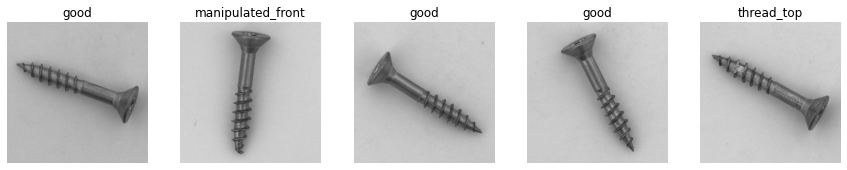

In [6]:
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
    for i in range(5):
        ax = plt.subplot(5, 5, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i].numpy())])
        plt.axis("off")

## Data pipeline

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = (
    train_ds
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
test_ds = (
    test_ds
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
valid_ds = (
    valid_ds
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

## Konvoluční neuronová síť

### Normalization

In [8]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
valid_ds = valid_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

### Data augmentation

### Předtrénovaná síť

In [9]:
base_model = tf.keras.applications.vgg19.VGG19(
    include_top=False,
    weights='imagenet',
    input_shape= input_shape)

# Freeze the base_model
base_model.trainable = False

### Tvorba modelu

In [10]:
def cnn_model():
    model = tf.keras.Sequential()
    
    # model.add(data_augmentation) 
    
    #Pretrained base
    model.add(base_model)
    
    model.add(tf.keras.layers.Flatten())

    #Head
    model.add(tf.keras.layers.Dense(64,
                                    activation='relu'))
    model.add(tf.keras.layers.Dense(16,
                                    activation='relu'))    
    model.add(tf.keras.layers.Dense(6,
                                    activation='softmax'))

    return model

In [11]:
model1 =  cnn_model()

### Konfigurace modelu pro trénování

+ Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.

    + https://www.tensorflow.org/api_docs/python/tf/keras/optimizers

In [12]:
optimizer =tf.keras.optimizers.Adam(learning_rate=1e-5)

In [13]:
model1.compile(
    optimizer = optimizer,
    loss = 'categorical_crossentropy',
    metrics=['accuracy'],
)

### Early stopping

In [14]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=100,
    verbose=1,
    mode='min',
    baseline=None,
    restore_best_weights=True
)

## Trénování modelu

In [15]:
history = model1.fit(
    train_ds,
    validation_data = valid_ds,
    epochs=600,
    verbose = 1,
    callbacks=early_stopping
    )

Epoch 1/600
8/8 [==============================] - 24s 2s/step - loss: 1.2886 - accuracy: 0.6555 - val_loss: 1.1774 - val_accuracy: 0.7660
Epoch 2/600
8/8 [==============================] - 4s 477ms/step - loss: 1.1028 - accuracy: 0.7563 - val_loss: 1.0386 - val_accuracy: 0.7660
Epoch 3/600
8/8 [==============================] - 4s 478ms/step - loss: 1.0126 - accuracy: 0.7563 - val_loss: 0.9785 - val_accuracy: 0.7660
Epoch 4/600
8/8 [==============================] - 4s 478ms/step - loss: 0.9800 - accuracy: 0.7563 - val_loss: 0.9626 - val_accuracy: 0.7660
Epoch 5/600
8/8 [==============================] - 4s 479ms/step - loss: 0.9601 - accuracy: 0.7563 - val_loss: 0.9543 - val_accuracy: 0.7660
Epoch 6/600
8/8 [==============================] - 4s 480ms/step - loss: 0.9473 - accuracy: 0.7563 - val_loss: 0.9452 - val_accuracy: 0.7660
Epoch 7/600
8/8 [==============================] - 4s 480ms/step - loss: 0.9315 - accuracy: 0.7563 - val_loss: 0.9425 - val_accuracy: 0.7660
Epoch 8/600
8/8

Epoch 59/600
8/8 [==============================] - 4s 537ms/step - loss: 0.5916 - accuracy: 0.8067 - val_loss: 0.8016 - val_accuracy: 0.7660
Epoch 60/600
8/8 [==============================] - 4s 536ms/step - loss: 0.5853 - accuracy: 0.8025 - val_loss: 0.8018 - val_accuracy: 0.7660
Epoch 61/600
8/8 [==============================] - 4s 544ms/step - loss: 0.5992 - accuracy: 0.8067 - val_loss: 0.7992 - val_accuracy: 0.7660
Epoch 62/600
8/8 [==============================] - 4s 547ms/step - loss: 0.5980 - accuracy: 0.7983 - val_loss: 0.7907 - val_accuracy: 0.7660
Epoch 63/600
8/8 [==============================] - 4s 537ms/step - loss: 0.5906 - accuracy: 0.7983 - val_loss: 0.7925 - val_accuracy: 0.7660
Epoch 64/600
8/8 [==============================] - 4s 544ms/step - loss: 0.5842 - accuracy: 0.7983 - val_loss: 0.7876 - val_accuracy: 0.7660
Epoch 65/600
8/8 [==============================] - 4s 537ms/step - loss: 0.5751 - accuracy: 0.8067 - val_loss: 0.7993 - val_accuracy: 0.7660
Epoch 

8/8 [==============================] - 4s 541ms/step - loss: 0.3225 - accuracy: 0.8655 - val_loss: 0.7691 - val_accuracy: 0.8014
Epoch 174/600
8/8 [==============================] - 4s 548ms/step - loss: 0.3130 - accuracy: 0.8571 - val_loss: 0.7424 - val_accuracy: 0.8014
Epoch 175/600
8/8 [==============================] - 4s 559ms/step - loss: 0.3120 - accuracy: 0.8571 - val_loss: 0.7249 - val_accuracy: 0.8014
Epoch 176/600
8/8 [==============================] - 4s 546ms/step - loss: 0.3089 - accuracy: 0.8697 - val_loss: 0.7557 - val_accuracy: 0.8014
Epoch 177/600
8/8 [==============================] - 4s 542ms/step - loss: 0.3120 - accuracy: 0.8782 - val_loss: 0.7707 - val_accuracy: 0.8014
Epoch 178/600
8/8 [==============================] - 4s 542ms/step - loss: 0.3110 - accuracy: 0.8782 - val_loss: 0.7701 - val_accuracy: 0.8014
Epoch 179/600
8/8 [==============================] - 4s 541ms/step - loss: 0.3075 - accuracy: 0.8697 - val_loss: 0.7493 - val_accuracy: 0.8014
Epoch 180/600

In [16]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [17]:
data_augmentation.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [18]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 64)                1605696   
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dense_2 (Dense)             (None, 6)                 102       
                                                                 
Total params: 21,631,222
Trainable params: 1,606,838
N

## Vlastnosti modelu

### Uložení modelu

In [ ]:
model_to_save = r"C:\Users\HP\Documents\GIT\models\pretrained_base+NN(same_orientation#83,2%)"
model1.save(filepath=model_to_save , save_format='tf')

###  Načtení modelu

In [ ]:
model_name = r"C:\Users\HP\Documents\GIT\models\\"

load_model = tf.keras.models.load_model(model_name)

## Vizualizace přesnosti a ztráty naučeného modelu

In [ ]:
print(history.history.keys())

In [19]:
def plot_accuracy_loss(history):

    fig = plt.figure(figsize=(16,10))
    plt.rcParams['font.size'] = '16'
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(16)

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'b-', label = "Na trénovacích datech")
    plt.plot(history.history['val_accuracy'], 'r-', label = "Na validačních datech")
    plt.ylabel("Správnost",fontsize=18)
    plt.xlabel("Iterace",fontsize=18)
    plt.legend(fontsize=16)

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'b-', label = "Na trénovacích datech")
    plt.plot(history.history['val_loss'], 'r-', label = "Na validačních datech")
    plt.ylabel("Ztráta",fontsize=18)
    plt.xlabel("Iterace",fontsize=18)

    plt.legend(fontsize=16)
    plt.show()
    
history_frame = pd.DataFrame(history.history)

       loss  accuracy  val_loss  val_accuracy
0  1.288635  0.655462  1.177432      0.765957
1  1.102764  0.756303  1.038575      0.765957
2  1.012642  0.756303  0.978480      0.765957
3  0.980039  0.756303  0.962629      0.765957
4  0.960129  0.756303  0.954286      0.765957


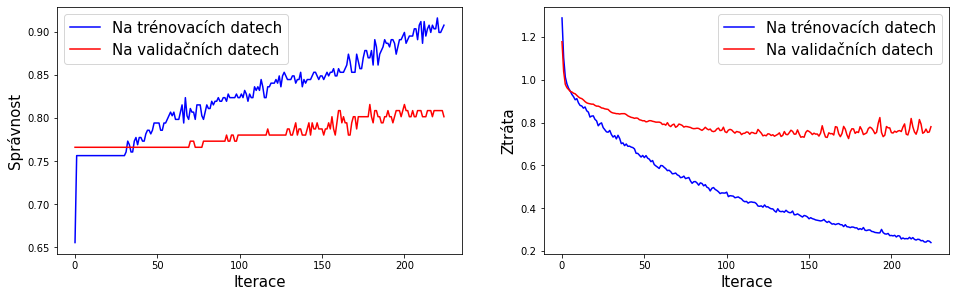

In [20]:
print(history_frame.head())
plot_accuracy_loss(history)

In [24]:
test_loss, test_acc = model1.evaluate(test_ds)
print(str(test_acc*100) + '%')

4/4 [==============================] - 1s 216ms/step - loss: 0.9733 - accuracy: 0.7327
73.26732873916626%


## Matice záměn (Confusion matrix)

+ https://stackoverflow.com/questions/64622210/how-to-plot-confusion-matrix-for-prefetched-dataset-in-tensorflow
+ https://deeplizard.com/learn/video/km7pxKy4UHU

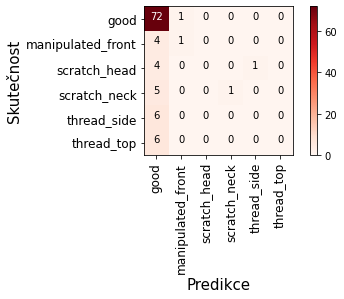

In [28]:
# Predikované rozdělení obrázků do tříd
image_predict = model1.predict(test_ds)
#print(image_predict)
image_predict = np.argmax(image_predict, axis=1)

# Skutečné rozdělení obrázků
image_true = tf.concat([y for x, y in test_ds], axis=0)
image_true = np.argmax(image_true, axis=1)

cm = confusion_matrix(y_true=image_true, y_pred=image_predict)


def plot_confusion_matrix(cm, classes,cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90,fontsize=12)
    plt.yticks(tick_marks, classes,fontsize=12)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Skutečnost',fontsize=15)
    plt.xlabel('Predikce',fontsize=15)
    
    
plot_confusion_matrix(cm=cm, classes=class_names)

In [26]:
print(classification_report(image_true, image_predict, target_names=class_names))

                   precision    recall  f1-score   support

             good       0.74      0.99      0.85        73
manipulated_front       0.50      0.20      0.29         5
     scratch_head       0.00      0.00      0.00         5
     scratch_neck       1.00      0.17      0.29         6
      thread_side       0.00      0.00      0.00         6
       thread_top       0.00      0.00      0.00         6

         accuracy                           0.73       101
        macro avg       0.37      0.23      0.24       101
     weighted avg       0.62      0.73      0.64       101



C:\Users\HP\miniconda3\envs\spyder-env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\miniconda3\envs\spyder-env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\miniconda3\envs\spyder-env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
